In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Параметры сделки (Range Accrual)
Notional = 1_000_000  # Номинал (например, 1 млн руб)
T_years = 1.0         # Срок сделки (1 год)
Lower_Barrier = 70.0  # Нижняя граница курса
Upper_Barrier = 80.0  # Верхняя граница курса

# Рыночные данные на 10.12.2021 (Старт)
S0 = 73.70    # Курс USDRUB
r_rub_0 = 0.0745  # RUONIA
r_usd_0 = 0.0005  # SOFR (около нуля)

# Параметры моделей (То, что мы откалибровали)
# RUB (CIR)
kappa_r, theta_r, sigma_r = 1.5546, 0.0582, 0.0936
# USD (CIR)
kappa_d, theta_d, sigma_d = 1.3472, 0.0022, 0.1695
# FX (LogNormal)
sigma_fx = 0.1391

In [ ]:
corr_data = [
    [1.0000, 0.0382, 0.0098],
    [0.0382, 1.0000, -0.0177],
    [0.0098, -0.0177, 1.0000]
]
corr_matrix = np.array(corr_data)

In [ ]:
N_sim = 10000   # Количество путей (10 тыс достаточно)
N_steps = 365   # Шагов по времени (каждый день)
dt = T_years / N_steps

In [ ]:
print(f"Запуск симуляции: {N_sim} путей, {N_steps} дней...")

🚀 Запуск симуляции: 10000 путей, 365 дней...


In [ ]:
L = np.linalg.cholesky(corr_matrix)

In [ ]:
rub_rates = np.zeros((N_sim, N_steps + 1))
usd_rates = np.zeros((N_sim, N_steps + 1))
fx_rates  = np.zeros((N_sim, N_steps + 1))

In [ ]:
rub_rates[:, 0] = r_rub_0
usd_rates[:, 0] = r_usd_0
fx_rates[:, 0]  = S0

In [ ]:
days_in_range = np.zeros(N_sim)

# Накопленный дисконт-фактор (интеграл ставки)
discount_integral = np.zeros(N_sim)

# Фиксируем seed для воспроизводимости
np.random.seed(42)

In [ ]:
for t in range(N_steps):
    # 1. Генерация случайных чисел (3 штуки на каждый путь)
    # Z_uncorr: размер (3, N_sim)
    Z_uncorr = np.random.normal(0, 1, size=(3, N_sim))

    # Коррелируем их
    Z = L @ Z_uncorr # Теперь Z[0] это шум RUB, Z[1] шум USD, Z[2] шум FX

    # Текущие значения
    r_r = rub_rates[:, t]
    r_d = usd_rates[:, t]
    S_t = fx_rates[:, t]

    # 2. Обновление ставки RUB (CIR)
    # Используем max(r, 0) под корнем, чтобы не вылететь в комплексные числа
    dr_r = kappa_r * (theta_r - r_r) * dt + sigma_r * np.sqrt(np.maximum(r_r, 0)) * np.sqrt(dt) * Z[0, :]
    rub_rates[:, t+1] = r_r + dr_r

    # 3. Обновление ставки USD (CIR)
    dr_d = kappa_d * (theta_d - r_d) * dt + sigma_d * np.sqrt(np.maximum(r_d, 0)) * np.sqrt(dt) * Z[1, :]
    usd_rates[:, t+1] = r_d + dr_d

    # 4. Обновление Курса (Стохастический дрифт!)
    # Дрифт курса = (r_rub - r_usd) - это риск-нейтральное условие!
    drift_fx = (r_r - r_d - 0.5 * sigma_fx**2) * dt
    diffusion_fx = sigma_fx * np.sqrt(dt) * Z[2, :]
    fx_rates[:, t+1] = S_t * np.exp(drift_fx + diffusion_fx)
    # 5. ПРОВЕРКА УСЛОВИЯ (Range Accrual Logic)
    # Курс на ЗАВТРА попал в диапазон?
    S_next = fx_rates[:, t+1]
    in_range_condition = (S_next >= Lower_Barrier) & (S_next <= Upper_Barrier)
    days_in_range += in_range_condition.astype(int)

    # 6. Накопление дисконта (по рублевой ставке, т.к. платим в рублях)
    discount_integral += r_r * dt

In [ ]:
# Доля дней в диапазоне (Accrual Fraction)
accrual_fraction = days_in_range / N_steps

# Выплата в конце срока (без дисконтирования)
payoff = Notional * accrual_fraction

# Дисконт-фактор для каждого пути
df = np.exp(-discount_integral)

# Приведенная стоимость (PV) для каждого пути
pv_paths = payoff * df

# Справедливая цена = Среднее по всем путям
fair_value = pv_paths.mean()
std_error = pv_paths.std() / np.sqrt(N_sim)

In [ ]:
print("\n" + "="*40)
print(f"💰 РЕЗУЛЬТАТ ОЦЕНКИ RANGE ACCRUAL")
print("="*40)
print(f"Диапазон:         {Lower_Barrier} - {Upper_Barrier} RUB")
print(f"Справедливая цена: {fair_value:,.2f} RUB")
print(f"В % от номинала:   {(fair_value/Notional)*100:.2f}%")
print(f"Точность (StdErr): +/- {std_error:.2f}")


💰 РЕЗУЛЬТАТ ОЦЕНКИ RANGE ACCRUAL
Диапазон:         70.0 - 80.0 RUB
Справедливая цена: 523,081.63 RUB
В % от номинала:   52.31%
Точность (StdErr): +/- 2458.87


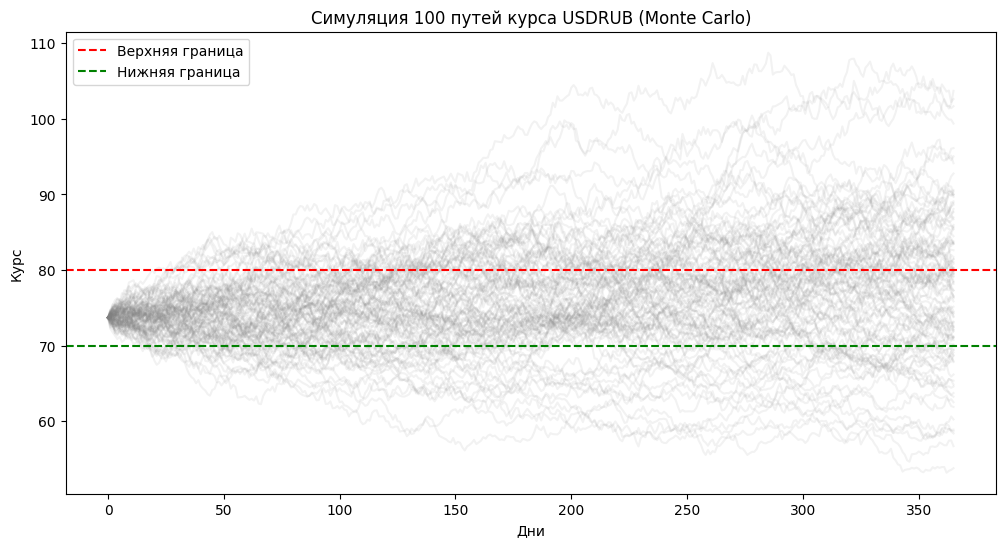

In [ ]:
# === 4. ВИЗУАЛИЗАЦИЯ (Для красоты отчета) ===
plt.figure(figsize=(12, 6))
# Рисуем первые 100 путей
plt.plot(fx_rates[:100, :].T, color='gray', alpha=0.1)
# Рисуем границы
plt.axhline(Upper_Barrier, color='red', linestyle='--', label='Верхняя граница')
plt.axhline(Lower_Barrier, color='green', linestyle='--', label='Нижняя граница')
plt.title('Симуляция 100 путей курса USDRUB (Monte Carlo)')
plt.xlabel('Дни')
plt.ylabel('Курс')
plt.legend()
plt.show()